In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors
from sklearn.metrics import auc

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [4]:
def rename_zscore_cols(cell_line_dict):
    # Rename columns with senior authors
    for key, df in cell_line_dict.items():
        new_zscore_cols = ['Gene Symbol']
        zscore_cols = [col for col in df.columns if 'zscore' in col]
        for col in zscore_cols:
            if key not in col:
                new_col = col + '_' + key 
                new_zscore_cols.append(new_col)
        if len(new_zscore_cols) == len(df.columns):
            df.columns = new_zscore_cols
    return cell_line_dict

def resistant_hit_col(cell_line_df, greater_than = True):
    # Add bool col assigning 1 to resistance hits (score > 3)
    zscore_cols = [col for col in cell_line_df.columns if 'zscore' in col and 'Rank' not in col]
    primary_zscore_cols = [col for col in zscore_cols if 'primary' in col]
    secondary_zscore_col = [col for col in zscore_cols if 'secondary' in col][0]

    for col in zscore_cols:
        if col in primary_zscore_cols:
            primary_name = col.split('_')[-1]
            zscore_col_name = [col for col in zscore_cols if primary_name and 'primary' in col][0]
            name = primary_name + '_primary'
        else:
            secondary_name = col.split('_')[-1]
            zscore_col_name = [col for col in zscore_cols if secondary_name and 'secondary' in col][0]
            
            name = secondary_name + '_secondary'
        
        print(zscore_col_name)
        if greater_than:
            cell_line_df[name + '_resistant_hit'] = (cell_line_df[zscore_col_name] > 3).astype(int)
        else:
            cell_line_df[name + '_resistant_hit'] = (cell_line_df[zscore_col_name] < -3).astype(int)
    
    return cell_line_df


def cumulative_dist(df, annot_col, rank_col, bool_col, screen = None):

    cumulative_dist_df = df[['Gene Symbol']].copy()
    total_sum = df.loc[:, bool_col].sum()
    max_rank = max(df[rank_col])
    for i in range(len(df)):
#         print(df.loc[i, rank_col])
        fractional_rank = df.loc[i, rank_col]/max_rank
        cumulative_dist_df.loc[i, 'Fractional_rank'] = fractional_rank
        cumulative_sum = df.loc[:i, bool_col].sum()
        cumulative_freq = cumulative_sum/total_sum
        cumulative_dist_df.loc[i, 'Cumulative_freq'] = cumulative_freq
    
    auc_val = auc(cumulative_dist_df['Fractional_rank'], cumulative_dist_df['Cumulative_freq'])
    
    if screen:
        cumulative_dist_df['Screen'] = screen + ' (n = ' + str(total_sum) + ') , AUC = ' + str(round(auc_val, 2))
    
    return cumulative_dist_df, auc_val

global cumulative_dist_dict, cumulative_dist_auc_dict
cumulative_dist_dict = {}
cumulative_dist_auc_dict = {}

def run_cumulative_dist(cell_line_df, cell_line, ascending=False):

    zscore_cols = [col for col in cell_line_df.columns if 'zscore' in col and 'Rank' not in col]
    rank_cols = [col for col in cell_line_df.columns if 'Rank' in col]
    hit_cols = [col for col in cell_line_df.columns if 'hit' in col]
    cell_line_df = cell_line_df.drop(rank_cols, axis=1)

    primary_zscore_cols = [col for col in zscore_cols if 'primary' in col]
    primary_hit_cols = [col for col in hit_cols if 'primary' in col]
    
    secondary_zscore_col = [col for col in zscore_cols if 'secondary' in col][0]
    secondary_hit_col = [col for col in hit_cols if 'secondary' in col][0]

    for primary_zscore in primary_zscore_cols:
        primary_author = primary_zscore.split('_')[-1]
        primary_df = cell_line_df[['Gene Symbol', primary_zscore, secondary_hit_col]].dropna().sort_values(by=primary_zscore, ascending=ascending).reset_index(drop=True)
        # Re-assign rank column 
        primary_rank_col = primary_author+'_primary_rank'
        primary_df[primary_rank_col] = primary_df[primary_zscore].rank(method='min', ascending=ascending)
        
        key = cell_line + '_' + primary_author + '_primary_rank_Goujon_secondary_hit'
        print(key)
        # Rank by primary screen
        primary_rank_df, primary_rank_auc = cumulative_dist(df=primary_df, annot_col = 'Gene Symbol', rank_col = primary_rank_col, bool_col = secondary_hit_col, screen=key)
        
        cumulative_dist_dict[key] = primary_rank_df
        cumulative_dist_auc_dict[key] = primary_rank_auc

    for primary_hit in primary_hit_cols:
        primary_author = primary_hit.split('_')[0]
        secondary_df = cell_line_df[['Gene Symbol', secondary_zscore_col, primary_hit]].dropna().sort_values(by=secondary_zscore_col, ascending=ascending).reset_index(drop=True)
        # Re-assign rank column 
        secondary_rank_col = 'Goujon_secondary_rank'
        secondary_df[secondary_rank_col] = secondary_df[secondary_zscore_col].rank(method='min', ascending=ascending)
        
        key = cell_line + '_Goujon_secondary_rank_' + primary_author+'_primary_hit'
        print(key)
        # Rank by secondary screen
        secondary_rank_df, secondary_rank_auc = cumulative_dist(df=secondary_df, annot_col = 'Gene Symbol', rank_col = secondary_rank_col, bool_col = primary_hit, screen=key)

        cumulative_dist_dict[key] = secondary_rank_df
        cumulative_dist_auc_dict[key] = secondary_rank_auc
    
    
def select_top_ranks(df, cols_to_rank=None, rank = 5, largest = True): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    if not cols_to_rank:
        rank_cols = df.columns.to_list()[1:]
    else:
        rank_cols = cols_to_rank
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        if largest == True:
            top_rank_rows = df.copy().nlargest(rank, col) 
        else: 
            top_rank_rows = df.copy().nsmallest(rank, col) 
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df

## Fig. 2e: Primary vs secondary cumulative distribution plots

* Primary Cas9: 
    * A549:
        * Sanjana (KO)
        * Zhang (KO)
    * Huh-7.5:
        * Poirier (KO)
        * Puschnik (KO)
    * Caco-2: 
        * Goujon (KO)
    * Calu-3:
        * Goujon (KO)
        * Goujon (Activation)
<br/>
<b>vs</b>        
<br/>
* Secondary KO:
    * A549:
        * Cas9 KO Secondary
    * Huh-7.5.1:
        * Cas9 KO Secondary
    * Caco-2: 
        * Cas9 KO Secondary
    * Calu-3:
        * Cas9 KO Secondary
        * Cas9 Activation Secondary

### Read Primary KO screen data

In [5]:
cell_lines = ['A549', 'Huh7_5', 'Caco_2', 'Calu_3']

A549_dict = {}
Huh7_5_dict = {}
Caco2_dict = {}
Calu3_KO_dict = {}
Calu3_Act_dict = {}

# A549
A549_dict['primary_KO_Sanjana'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/A549_GeCKOv2_Sanjana_v2.xlsx')
A549_dict['primary_KO_Zhang'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/A549_Brunello_Zhang.xlsx')

# Huh-7.5
Huh7_5_dict['primary_KO_Poirier'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/Huh75_Brunello_Poirier_v2.xlsx')
Huh7_5_dict['primary_KO_Puschnik'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/Huh751_GeCKOv2_Puschnik.xlsx')

# Caco-2
Caco2_dict['primary_KO_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/Caco2_Brunello_Goujon_v2.xlsx')

# Calu-3
Calu3_KO_dict['primary_KO_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/Calu3_Gattinara_Goujon_v2.xlsx')
Calu3_Act_dict['primary_Act_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/Calu3_Calabrese_Goujon_v3.xlsx')



### Read Secondary screen data

In [6]:
# A549
A549_dict['secondary_KO_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/A549_Cas9SecondaryLibraryKO_Goujon.xlsx')

# Huh-7.5
Huh7_5_dict['secondary_KO_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Huh751_Cas9SecondaryLibraryKO_Goujon.xlsx')

# Caco-2
Caco2_dict['secondary_KO_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Caco2_Cas9SecondaryLibraryKO_Goujon.xlsx')                                          

# Calu-3
Calu3_KO_dict['secondary_KO_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Calu3_SecondaryLibraryKO_Goujon.xlsx')
Calu3_Act_dict['secondary_Act_Goujon'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Calu3_SecondaryLibraryAct_Goujon.xlsx')


### Assign hits and ranks

In [7]:
# Rename columns with senior authors

A549_dict = rename_zscore_cols(A549_dict)

Huh7_5_dict = rename_zscore_cols(Huh7_5_dict)

Caco2_dict = rename_zscore_cols(Caco2_dict)

Calu3_KO_dict = rename_zscore_cols(Calu3_KO_dict)
Calu3_Act_dict = rename_zscore_cols(Calu3_Act_dict)


In [8]:
# Merge dfs for each cell line into one df
cell_line_dict = {}

cell_line_dict['A549'] = fns.merge_dict_dfs(A549_dict)

cell_line_dict['Huh7_5'] = fns.merge_dict_dfs(Huh7_5_dict)

cell_line_dict['Caco2'] = fns.merge_dict_dfs(Caco2_dict)

cell_line_dict['Calu3_KO'] = fns.merge_dict_dfs(Calu3_KO_dict)
cell_line_dict['Calu3_Act'] = fns.merge_dict_dfs(Calu3_Act_dict)


In [9]:
# Add bool col assigning 1 to resistance hits (score > 3)

for key, df in cell_line_dict.items():
    if 'Act' in key:
        df = resistant_hit_col(df, greater_than=False)
    else:
        df = resistant_hit_col(df)
    cell_line_dict[key] = df

# A549_df = resistant_hit_col(A549_df)

# Huh7_5_df = resistant_hit_col(Huh7_5_df)

# Caco2_df = resistant_hit_col(Caco2_df)

# Calu3_KO_df = resistant_hit_col(Calu3_KO_df)
# Calu3_Act_df = resistant_hit_col(Calu3_Act_df)


residual_zscore_avg_primary_KO_Sanjana
residual_zscore_avg_primary_KO_Sanjana
residual_zscore_avg_secondary_KO_Goujon
residual_zscore_avg_primary_KO_Poirier
residual_zscore_avg_primary_KO_Poirier
residual_zscore_avg_secondary_KO_Goujon
residual_zscore_avg_primary_KO_Goujon
residual_zscore_avg_secondary_KO_Goujon
residual_zscore_avg_primary_KO_Goujon
residual_zscore_avg_secondary_KO_Goujon
residual_zscore_avg_primary_Act_Goujon
residual_zscore_avg_secondary_Act_Goujon


In [10]:
# run_cumulative_dist(A549_df, 'A549')
for key, df in cell_line_dict.items():
    if 'Act' in key:
        run_cumulative_dist(df, key, ascending=True)
    else:
        run_cumulative_dist(df, key)
#     break

A549_Sanjana_primary_rank_Goujon_secondary_hit
A549_Zhang_primary_rank_Goujon_secondary_hit
A549_Goujon_secondary_rank_Sanjana_primary_hit
A549_Goujon_secondary_rank_Zhang_primary_hit
Huh7_5_Poirier_primary_rank_Goujon_secondary_hit
Huh7_5_Puschnik_primary_rank_Goujon_secondary_hit
Huh7_5_Goujon_secondary_rank_Poirier_primary_hit
Huh7_5_Goujon_secondary_rank_Puschnik_primary_hit
Caco2_Goujon_primary_rank_Goujon_secondary_hit
Caco2_Goujon_secondary_rank_Goujon_primary_hit
Calu3_KO_Goujon_primary_rank_Goujon_secondary_hit
Calu3_KO_Goujon_secondary_rank_Goujon_primary_hit
Calu3_Act_Goujon_primary_rank_Goujon_secondary_hit
Calu3_Act_Goujon_secondary_rank_Goujon_primary_hit


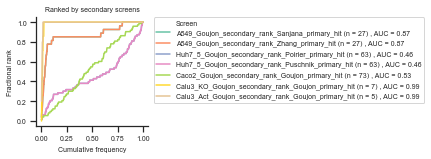

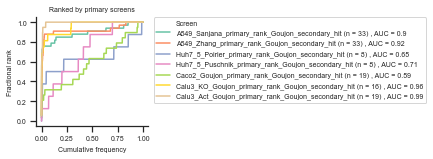

In [11]:
# Res_Wilen_rank, Res_Wilen_auc = cumulative_dist(df=Vero_zscores, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Wilen', bool_col = 'Goujon_resistance_hit', condition = 'Resistance')
# Sen_Wilen_rank, Sen_Wilen_auc = cumulative_dist(df=Vero_zscores_sensitization_Wilen_ranked, annot_col = 'Gene Symbol', rank_col = 'Rank_residual_zscore_avg_Wilen_sen', bool_col = 'Goujon_sensitization_hit', condition = 'Sensitization')

# Wilen_rank = pd.concat([Res_Wilen_rank, Sen_Wilen_rank])

primary_rank_cumulative_dist_dict = {key: value for key, value in cumulative_dist_dict.items() if 'primary_rank' in key}
secondary_rank_cumulative_dist_dict = {key: value for key, value in cumulative_dist_dict.items() if 'secondary_rank' in key}

fig, ax = plt.subplots(figsize=(2,2))
# Concatenate dfs in dict
secondary_rank_cumulative_dist_df = pd.concat(secondary_rank_cumulative_dist_dict.values())

s = sns.lineplot(data = secondary_rank_cumulative_dist_df, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue='Screen')
plt.legend(prop={'size':7}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Ranked by secondary screens', fontsize=7)
plt.xlabel('Cumulative frequency', fontsize=7)
plt.ylabel('Fractional rank', fontsize=7)
ax.tick_params(axis='both', labelsize=7)
sns.despine()
        
fig.savefig('../../../Figures/Cumulative_dist_Goujon_secondary_rank_primary_hit.png', bbox_inches='tight', dpi=300)
gpp.savefig('../../../Figures/Cumulative_dist_Goujon_secondary_rank_primary_hit.pdf', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots(figsize=(2,2))
# Concatenate dfs in dict
primary_rank_cumulative_dist_df = pd.concat(primary_rank_cumulative_dist_dict.values())

s = sns.lineplot(data = primary_rank_cumulative_dist_df, x = 'Fractional_rank', y = 'Cumulative_freq', ci=None, hue='Screen')
plt.legend(prop={'size':7}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Ranked by primary screens', fontsize=7)
plt.xlabel('Cumulative frequency', fontsize=7)
plt.ylabel('Fractional rank', fontsize=7)
ax.tick_params(axis='both', labelsize=7)
sns.despine()
        
fig.savefig('../../../Figures/Cumulative_dist_primary_rank_secondary_hit.png', bbox_inches='tight', dpi=300)
gpp.savefig('../../../Figures/Cumulative_dist_primary_rank_secondary_hit.pdf', bbox_inches='tight', dpi=300)


## Secondary screen Heatmaps

### KO

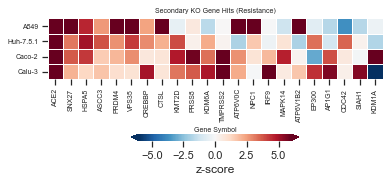

In [12]:
cell_line_dicts = {'A549':A549_dict, 'Huh7_5': Huh7_5_dict, 'Caco2': Caco2_dict, 'Calu3': Calu3_KO_dict}
secondary_KO_dict = {}

for cell_line, dictionary in cell_line_dicts.items():
    secondary_key = [key for key in dictionary.keys() if 'secondary' in key][0]
    secondary_df = dictionary[secondary_key]
    for col in secondary_df.columns:
        if 'zscore' in col:
            new_col_name = col + '_' + cell_line
            secondary_df = secondary_df.rename(columns={col:new_col_name})
    secondary_dict_key = cell_line + '_' + secondary_key
    secondary_KO_dict[cell_line] = secondary_df

secondary_KO_df = fns.merge_dict_dfs(secondary_KO_dict)
rank_cols = [col for col in secondary_KO_df.columns if 'Rank' in col]
secondary_KO_df['Avg_Rank'] = secondary_KO_df[rank_cols].mean(axis=1)

secondary_KO_heatmap_df = secondary_KO_df.copy().drop(rank_cols, axis=1)

zscore_cols = [col for col in secondary_KO_heatmap_df.columns if 'zscore' in col and 'Rank' not in col]
# Sort by average rank
secondary_KO_heatmap_df = select_top_ranks(secondary_KO_heatmap_df, cols_to_rank=zscore_cols, rank=7).set_index('Gene Symbol').sort_values('Avg_Rank')


secondary_KO_heatmap_df = secondary_KO_heatmap_df.drop('Avg_Rank', axis=1)

ylabels = ['A549', 'Huh-7.5.1', 'Caco-2', 'Calu-3']

g = sns.heatmap(secondary_KO_heatmap_df.T, mask = secondary_KO_heatmap_df.T.isnull(), cmap = gpp.diverging_cmap(), square=True, yticklabels=ylabels,xticklabels=True,#yticklabels=ylabels,
                center=0, annot=False, cbar_kws={'orientation':'horizontal','shrink':0.5,'extend':'both', 'label':'z-score', 'pad':0.25}, linecolor='white', linewidths=0.5, vmin = -6, vmax = 6);#, 'orientation': orientation});#, vmin = vmin, vmax = vmax, fmt='.2f')

plt.title('Secondary KO Gene Hits (Resistance)', fontsize=7)
plt.yticks(rotation = 0, fontsize=7)
plt.xticks(fontsize=7)
plt.xlabel('Gene Symbol',fontsize=7);

fig.savefig('../../../Figures/Heatmaps/SecondaryKOHeatmapComparison_res.png', bbox_inches='tight', dpi=300)
gpp.savefig('../../../Figures/Heatmaps/SecondaryKOHeatmapComparison_res.pdf', bbox_inches='tight', dpi=300)



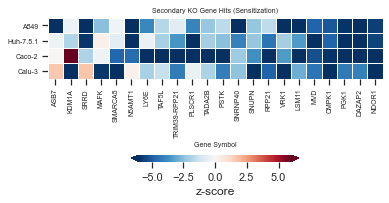

In [53]:
cell_line_dicts = {'A549':A549_dict, 'Huh7_5': Huh7_5_dict, 'Caco2': Caco2_dict, 'Calu3': Calu3_KO_dict}
secondary_KO_dict = {}

for cell_line, dictionary in cell_line_dicts.items():
    secondary_key = [key for key in dictionary.keys() if 'secondary' in key][0]
    secondary_df = dictionary[secondary_key]
    for col in secondary_df.columns:
        if 'zscore' in col:
            new_col_name = col + '_' + cell_line
            secondary_df = secondary_df.rename(columns={col:new_col_name})
    secondary_dict_key = cell_line + '_' + secondary_key
    secondary_KO_dict[cell_line] = secondary_df

secondary_KO_df = fns.merge_dict_dfs(secondary_KO_dict)
rank_cols = [col for col in secondary_KO_df.columns if 'Rank' in col]
secondary_KO_df['Avg_Rank'] = secondary_KO_df[rank_cols].mean(axis=1)

secondary_KO_heatmap_df = secondary_KO_df.copy().drop(rank_cols, axis=1)

zscore_cols = [col for col in secondary_KO_heatmap_df.columns if 'zscore' in col and 'Rank' not in col]
# Sort by average rank
secondary_KO_heatmap_df = select_top_ranks(secondary_KO_heatmap_df, cols_to_rank=zscore_cols, rank=7, largest=False).set_index('Gene Symbol').sort_values('Avg_Rank')


secondary_KO_heatmap_df = secondary_KO_heatmap_df.drop('Avg_Rank', axis=1)

ylabels = ['A549', 'Huh-7.5.1', 'Caco-2', 'Calu-3']

g = sns.heatmap(secondary_KO_heatmap_df.T, mask = secondary_KO_heatmap_df.T.isnull(), cmap = gpp.diverging_cmap(), square=True, yticklabels=ylabels,xticklabels=True,#yticklabels=ylabels,
                center=0, annot=False, cbar_kws={'orientation':'horizontal','shrink':0.5,'extend':'both', 'label':'z-score', 'pad':0.35}, linecolor='white', linewidths=0.5, vmin = -6, vmax = 6);#, 'orientation': orientation});#, vmin = vmin, vmax = vmax, fmt='.2f')

plt.title('Secondary KO Gene Hits (Sensitization)', fontsize=7)
plt.yticks(rotation = 0, fontsize=7)
plt.xticks(fontsize=7)
plt.xlabel('Gene Symbol',fontsize=7);

fig.savefig('../../../Figures/Heatmaps/SecondaryKOHeatmapComparison_sen.png', bbox_inches='tight', dpi=300)
gpp.savefig('../../../Figures/Heatmaps/SecondaryKOHeatmapComparison_sen.pdf', bbox_inches='tight', dpi=300)



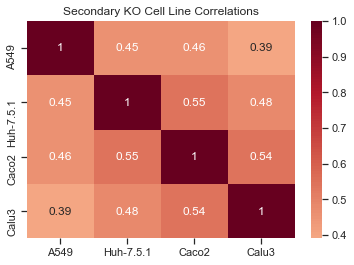

In [25]:
rank_cols = [col for col in secondary_KO_df.columns if 'Rank' in col]
secondary_KO_corr_df = secondary_KO_df.drop(rank_cols, axis=1)[1:]

for col in secondary_KO_corr_df.columns:
    if 'Huh' in col:
        new_col = 'Huh-7.5.1'
    else:
        new_col = col.split('_')[-1]
    secondary_KO_corr_df = secondary_KO_corr_df.rename(columns={col:new_col})
# fig, ax = plt.subplots()

sns.heatmap(secondary_KO_corr_df.corr(), cmap = gpp.diverging_cmap(), center=0, annot=True)
plt.title('Secondary KO Cell Line Correlations');
fig = plt.gcf()

fig.savefig('../../../Figures/SecondaryKOCellLineCorrelations.png', bbox_inches = 'tight', dpi=300)


### Activation

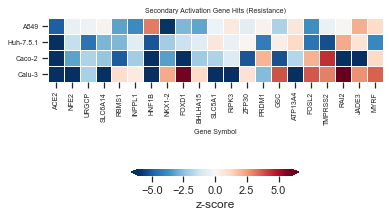

In [60]:
secondary_Act_dict = {}

secondary_Act_dict['A549'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/A549_SecondaryLibraryAct_Goujon.xlsx')
secondary_Act_dict['Huh7_5'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Huh751_SecondaryLibraryAct_Goujon.xlsx')
secondary_Act_dict['Caco2'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Caco2_SecondaryLibraryAct_Goujon.xlsx')
secondary_Act_dict['Calu3'] = Calu3_Act_dict['secondary_Act_Goujon']

for cell_line, df in secondary_Act_dict.items():
    for col in df.columns:
        if 'zscore' in col:
            new_col_name = col + '_secondary_Act_' + cell_line
            df = df.copy().rename(columns={col:new_col_name})
    secondary_Act_dict[cell_line] = df


secondary_Act_df = fns.merge_dict_dfs(secondary_Act_dict)
rank_cols = [col for col in secondary_Act_df.columns if 'Rank' in col]
secondary_Act_df['Avg_Rank'] = secondary_Act_df[rank_cols].mean(axis=1)

secondary_Act_heatmap_res_df = secondary_Act_df.copy().drop(rank_cols, axis=1)

zscore_cols = [col for col in secondary_Act_heatmap_res_df.columns if 'zscore' in col and 'Rank' not in col]


# Sort by average rank
secondary_Act_heatmap_res_df = secondary_Act_heatmap_res_df[secondary_Act_heatmap_res_df['Gene Symbol']!='URGCP-MRPS24']

secondary_Act_heatmap_res_df = select_top_ranks(secondary_Act_heatmap_res_df, cols_to_rank=zscore_cols, rank=7, largest=False).set_index('Gene Symbol').sort_values('Avg_Rank')


secondary_Act_heatmap_res_df = secondary_Act_heatmap_res_df.drop('Avg_Rank', axis=1)

ylabels = ['A549', 'Huh-7.5.1', 'Caco-2', 'Calu-3']

g = sns.heatmap(secondary_Act_heatmap_res_df.T, mask = secondary_Act_heatmap_res_df.T.isnull(), cmap = gpp.diverging_cmap(), square=True, yticklabels=ylabels,xticklabels=True,#yticklabels=ylabels,
                center=0, annot=False, cbar_kws={'orientation':'horizontal','shrink':0.5,'extend':'both', 'label':'z-score', 'pad':0.4}, linecolor='white', linewidths=0.5, vmin = -6, vmax = 6);#, 'orientation': orientation});#, vmin = vmin, vmax = vmax, fmt='.2f')

plt.title('Secondary Activation Gene Hits (Resistance)', fontsize=7)
plt.yticks(rotation = 0, fontsize=7)
plt.xticks(fontsize=7)
plt.xlabel('Gene Symbol',fontsize=7);

fig.savefig('../../../Figures/Heatmaps/SecondaryActHeatmapComparison_res.png', bbox_inches='tight', dpi=300)
gpp.savefig('../../../Figures/Heatmaps/SecondaryActHeatmapComparison_res.pdf', bbox_inches='tight', dpi=300)






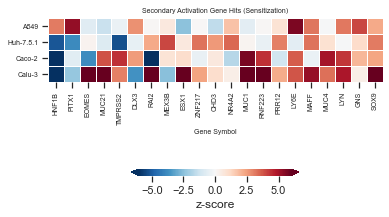

In [55]:
# secondary_Act_dict = {}

# secondary_Act_dict['A549'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/A549_SecondaryLibraryAct_Goujon.xlsx')
# secondary_Act_dict['Huh7_5'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Huh751_SecondaryLibraryAct_Goujon.xlsx')
# secondary_Act_dict['Caco2'] = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Caco2_SecondaryLibraryAct_Goujon.xlsx')
# secondary_Act_dict['Calu3'] = Calu3_Act_dict['secondary_Act_Goujon']

for cell_line, df in secondary_Act_dict.items():
    for col in df.columns:
        if 'zscore' in col:
            new_col_name = col + '_secondary_Act_' + cell_line
            df = df.copy().rename(columns={col:new_col_name})
    secondary_Act_dict[cell_line] = df


secondary_Act_df = fns.merge_dict_dfs(secondary_Act_dict)
rank_cols = [col for col in secondary_Act_df.columns if 'Rank' in col]
secondary_Act_df['Avg_Rank'] = secondary_Act_df[rank_cols].mean(axis=1)

secondary_Act_heatmap_df = secondary_Act_df.copy().drop(rank_cols, axis=1)

zscore_cols = [col for col in secondary_Act_heatmap_df.columns if 'zscore' in col and 'Rank' not in col]
# Sort by average rank
secondary_Act_heatmap_df = select_top_ranks(secondary_Act_heatmap_df, cols_to_rank=zscore_cols, rank=7).set_index('Gene Symbol').sort_values('Avg_Rank')


secondary_Act_heatmap_df = secondary_Act_heatmap_df.drop('Avg_Rank', axis=1)

ylabels = ['A549', 'Huh-7.5.1', 'Caco-2', 'Calu-3']

g = sns.heatmap(secondary_Act_heatmap_df.T, mask = secondary_Act_heatmap_df.T.isnull(), cmap = gpp.diverging_cmap(), square=True, yticklabels=ylabels,xticklabels=True,#yticklabels=ylabels,
                center=0, annot=False, cbar_kws={'orientation':'horizontal','shrink':0.5,'extend':'both', 'label':'z-score', 'pad':0.4}, linecolor='white', linewidths=0.5, vmin = -6, vmax = 6);#, 'orientation': orientation});#, vmin = vmin, vmax = vmax, fmt='.2f')

plt.title('Secondary Activation Gene Hits (Sensitization)', fontsize=7)
plt.yticks(rotation = 0, fontsize=7)
plt.xticks(fontsize=7)
plt.xlabel('Gene Symbol',fontsize=7);

fig.savefig('../../../Figures/Heatmaps/SecondaryActHeatmapComparison_sen.png', bbox_inches='tight', dpi=300)
gpp.savefig('../../../Figures/Heatmaps/SecondaryActHeatmapComparison_sen.pdf', bbox_inches='tight', dpi=300)






## Secondary KO vs Act Scatterplots

179
179
179
179


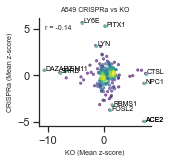

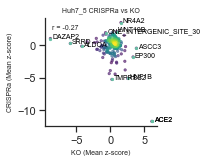

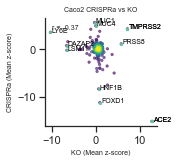

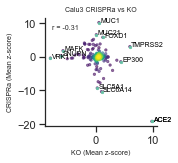

In [49]:
for cell_line, ko_df in secondary_KO_dict.items():
    ko_zscore_col = [col for col in ko_df.columns if 'zscore' in col and 'Rank' not in col][0]
    act_df = secondary_Act_dict[cell_line]
    act_zscore_col = [col for col in act_df.columns if 'zscore' in col and 'Rank' not in col][0]
    actvsko_df = pd.merge(ko_df, act_df, on = 'Gene Symbol', how = 'inner')
    print(len(actvsko_df))
    
    fig, ax = plt.subplots(figsize=(2,2))
    ax = gpp.point_densityplot(actvsko_df, ko_zscore_col, act_zscore_col, s=6)
    ax = gpp.add_correlation(actvsko_df, ko_zscore_col, act_zscore_col, fontsize=7)
    
    # Annotate
    top_ranked_ko_df = actvsko_df.nlargest(3, ko_zscore_col)
    bottom_ranked_ko_df = actvsko_df.nsmallest(3, ko_zscore_col)
    top_ranked_act_df = actvsko_df.nlargest(3, act_zscore_col)
    bottom_ranked_act_df = actvsko_df.nsmallest(3, act_zscore_col)
    
    ranked_ko_df = pd.concat([top_ranked_ko_df, bottom_ranked_ko_df])
    ranked_act_df = pd.concat([top_ranked_act_df, bottom_ranked_act_df])
    annot_df = pd.concat([ranked_ko_df, ranked_act_df])
    
    sns.scatterplot(data=annot_df, x=ko_zscore_col, y=act_zscore_col, color = sns.color_palette('Set2')[0], edgecolor=None, s=6)
    texts= []
    for j, row in annot_df.iterrows():
        texts.append(ax.text(row[ko_zscore_col]+0.25, row[act_zscore_col], row['Gene Symbol'], fontsize=7,
                                      color = 'black'))
    sns.despine()
    plt.title(cell_line+ ' CRISPRa vs KO', fontsize=7)
    plt.xlabel('KO (Mean z-score)', fontsize=7)
    plt.ylabel('CRISPRa (Mean z-score)', fontsize=7)
    
    gpp.savefig('../../../Figures/Scatterplots/'+cell_line+'SecondaryActvsKOscatterplot.pdf', dpi=300)
    
    
    
#     print(actvsko_df)

## Replicate correlations sample sizes 

In [35]:
screen_level_KO_dict = {}
screen_level_KO_dict['A549'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/A549_Cas9SecondaryLibraryKO_Goujon_indiv_screens.xlsx')
screen_level_KO_dict['Calu3'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/SecondaryLibraryIndivScreens/Calu3_SecondaryLibraryKO_Goujon_indiv_screens.xlsx')
screen_level_KO_dict['Caco2'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/Caco2_Cas9SecondaryLibraryKO_Goujon_indiv_screens.xlsx')
screen_level_KO_dict['Huh7_5'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/Huh751_Cas9SecondaryLibraryKO_Goujon_indiv_screens.xlsx')



In [36]:
screen_level_Act_dict = {}
screen_level_Act_dict['A549'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/SecondaryLibraryIndivScreens/A549_SecondaryLibraryAct_Goujon.xlsx')
screen_level_Act_dict['Calu3'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/SecondaryLibraryIndivScreens/Calu3_SecondaryLibraryAct_Goujon_indiv_screens.xlsx')
screen_level_Act_dict['Caco2'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/Caco2_SecondaryLibraryAct_Goujon_indiv_screens.xlsx')
screen_level_Act_dict['Huh7_5'] = pd.read_excel('../../../Data/Processed/Individual_screens_v2/SecondaryLibraryIndivScreens/Huh751_SecondaryLibraryAct_Goujon.xlsx')



In [48]:
for key, df in screen_level_KO_dict.items():
    print(key)
#     ko_df_1 = df[df['condition'].str.contains('#1')]
#     ko_df_2 = df[df['condition'].str.contains('#2')]
#     ko_z_df = pd.merge(ko_df_1[['Gene Symbol', 'residual_zscore']], ko_df_2[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
    ko_df = df
    
    act_df = screen_level_Act_dict[key]
#     act_df_1 = act_df[act_df['condition'].str.contains('#1')]
#     act_df_2 = act_df[act_df['condition'].str.contains('#2')]
#     act_z_df = pd.merge(act_df_1[['Gene Symbol', 'residual_zscore']], act_df_2[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
    
    
#     act_df = screen_level_Act_dict[key]
    print(key, 'KO', len(ko_df.dropna().drop_duplicates()))
    print(key, 'Act', len(act_df.dropna().drop_duplicates()))
    

A549
A549 KO 677
A549 Act 1640
Calu3
Calu3 KO 677
Calu3 Act 820
Caco2
Caco2 KO 677
Caco2 Act 820
Huh7_5
Huh7_5 KO 677
Huh7_5 Act 1640
